<a href="https://colab.research.google.com/github/mmsamiei/acv_final_project/blob/main/models_notebooks/GViT_ImageNet_L6_H512_P32_S32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install einops

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [5]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [1]:
!nvidia-smi

Tue Feb  9 16:15:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/imagenet_1.zip .

In [8]:
!unzip -q /content/imagenet_1.zip -d /

In [9]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder('/content/data/imagenet_images', transform=transform)
trainset, testset = torch.utils.data.random_split(dataset, [18000, len(dataset)-18000])

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

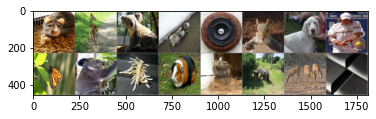

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels


In [12]:
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn

MIN_NUM_PATCHES = 16

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, stride, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (((image_size - patch_size)//stride)+1)**2    ###(image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective (at least 16). Try decreasing your patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_size = patch_size
        self.stride_size = stride
        self.unfolder = torch.nn.Unfold(kernel_size=(self.patch_size, self.patch_size), stride=(self.stride_size,self.stride_size)) 

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )



    def forward(self, img, mask = None):
        p = self.patch_size

        # x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.unfolder(img).permute(0,2,1)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, mask)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
v1 = ViT(
    image_size = 224,
    patch_size = 32,
    stride = 32,
    num_classes = 20,
    dim = 512,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

v1 = v1.to(dev)

print(count_parameters(v1))

20509716


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(v1.parameters(), lr=0.0001)

In [16]:
def evaluate(model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in tqdm(testloader, total=len(testloader)):
          images, labels = data[0].to(dev), data[1].to(dev)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %.3f %%' % (
      100 * correct / total))


In [17]:
loss_log = []
for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(dev), data[1].to(dev)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = v1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_log.append(loss.item())
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    evaluate(v1)
    v1 = v1.train()

print('Finished Training')


[1,  1000] loss: 2.492




Accuracy of the network on the 10000 test images: 33.490 %


[2,  1000] loss: 2.018




Accuracy of the network on the 10000 test images: 40.961 %


[3,  1000] loss: 1.806




Accuracy of the network on the 10000 test images: 42.573 %


[4,  1000] loss: 1.625




Accuracy of the network on the 10000 test images: 44.360 %


[5,  1000] loss: 1.445




Accuracy of the network on the 10000 test images: 44.125 %


[6,  1000] loss: 1.262




Accuracy of the network on the 10000 test images: 44.243 %


[7,  1000] loss: 1.089




Accuracy of the network on the 10000 test images: 44.272 %
Finished Training


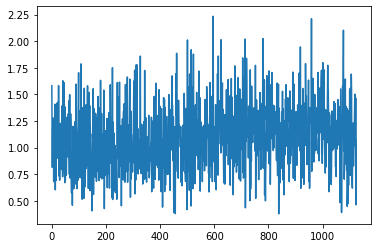

In [24]:
plt.plot(loss_log)
plt.show()